## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
#시드값 고정
np.random.seed(42)
%matplotlib inline

#KoNLPy 공식 문서 : https://konlpy.org/ko/latest/
#설치되었는지 확인 : pip install konlpy
try:
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt
except:
  !pip install konlpy
  from konlpy.tag import Hannanum, Kkma, Komoran, Okt

#LDA : 빈도수 기반 CountVectorizer 사용
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim

try:
  import pyLDAvis.gensim_models
except:
  !pip install pyLDAvis
  import pyLDAvis.gensim_models

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

try:
    from wordcloud import WordCloud, STOPWORDS
except:
    !pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
'''
------Code Lab------
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''
try:
  mpl.rc('font', family='NanumBarunGothic') 
except:
  !sudo apt-get install -y fonts-nanum
  !sudo fc-cache -fv
  !rm ~/.cache/matplotlib -rf
  mpl.rc('font', family='NanumBarunGothic')

In [3]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3813/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    plt.rc('font', family='NanumBarunGothic')
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def get_dct_corpus(year_quarter):
  nouns_list = [n.strip().split(',') for n in tqdm(open(f'/content/drive/MyDrive/LIS3813/datasets/nouns_{year_quarter}.csv', 'r', encoding='utf-8').readlines())][1:]

  #추출한 명사 리스트를 사전으로 만들기
  dic = gensim.corpora.Dictionary(nouns_list)
  
  #빈도가 4번 이하인 명사는 제외
  dic.filter_extremes(no_below = 4, no_above=0.05) 
  
  temp = dic[0] #dictionary 로드하기 위해서만 #이 줄 없으면 실행 안됨
  texts = nouns_list

  #corpus 만들기
  corpus=[dic.doc2bow(text)  for text in texts]

  return dic, texts, corpus

In [6]:
#일관성 점수 계산 => 일관성 점수가 높을수록 좋은 model
def compute_coherence_scores(dic, texts, corpus, start=1, end=11, sep=2):
    coherence_scores = []
    lda_model_list = []
    
    for num_topics in tqdm(range(start, end, sep)):
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dic.id2token, random_state=42)
        lda_model_list.append(lda_model)
        
        coherence_lda_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dic, coherence='c_v')
        coherence_scores.append(coherence_lda_model.get_coherence())
        
    return lda_model_list, coherence_scores

In [14]:
def coherence_scores_fig(dic, texts, corpus, year_quarter, start=1, end=11, sep=2):
  lda_model_list, coherence_scores = compute_coherence_scores(dic, texts, corpus, start, end, sep)

  x = range(start, end, sep)
  fig = plt.figure(figsize=(5, 5))
  plt.plot(x, coherence_scores, 'bo--', figure=fig)
  plt.xlabel('토픽 개수', fontsize=20)
  plt.ylabel('일관성 점수', fontsize=20)
  title_style = {'fontsize': 25, 'fontweight': 'bold'}
  plt.title(f'일관성 점수 시각화_{year_quarter}', fontdict = title_style)
  plt.legend(('coherence_values'), loc='best')
  save_fig(f'coherence_scores_fig{year_quarter}')

In [15]:
#wordcloud stopwords
stopwords = set([
                 '사람', '생각', '새끼', '정도', '내가', '진짜', '정말', '제발', '이유', '자체',
                 '본인', '나도', '지금', '대부분', '단어', '게시판', '댓글', '인정', '무엇', '이것', '저것',
                 '애초', '정도', '수준', '사실', '그게', '누가', '저런', '존나', '시발', '보고', '무슨', '이게',
                 '저게', '그게', '다른', '거임', '거기', '모든', '이면', '오히려', '때문', '때문에', '하나', '이제',
                 '소리', '여기'
])

ValueError: ignored

## '기타' 

### 2021년도 '기타'

In [17]:
dic, texts, corpus = get_dct_corpus('2021_etc')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 1552/1552 [00:00<00:00, 321475.62it/s]

Number of unique tokens: 561
Number of documents: 1551


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

그림 저장:  coherence_scores_fig2021_etc


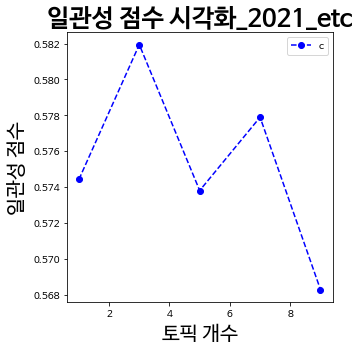

In [18]:
y_l = '2021_etc'
coherence_scores_fig(dic, texts, corpus, y_l)

In [ ]:
%%time 
lda_model_2021_etc = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42, update_every=1,
                              per_word_topics=True)

In [65]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_etc, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.861599873739952


In [73]:
topics = lda_model_2021_etc.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.047*"사람" + 0.042*"생각" + 0.031*"연대" + 0.018*"의대" + 0.017*"군대" + 0.013*"대학" + 0.013*"진짜" + 0.013*"공부" + 0.012*"장애인" + 0.011*"이대"
0.022*"수준" + 0.019*"의대생" + 0.017*"전문직" + 0.017*"새끼" + 0.016*"거지" + 0.016*"의사" + 0.015*"차별" + 0.015*"문제" + 0.014*"학교" + 0.014*"여자"


In [ ]:
texts

In [71]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    
    return(sent_topics_df)

In [72]:
format_topics_sentences(lda_model_2022_etc, corpus, texts)

IndexError: ignored

In [67]:
lda_vis_2021_etc = pyLDAvis.gensim_models.prepare(lda_model_2021_etc, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_etc, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_etc.html')
pyLDAvis.display(lda_vis_2021_etc)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### 2022년도 "기타"

In [8]:
dic, texts, corpus = get_dct_corpus('2022_etc')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 6519/6519 [00:00<00:00, 874182.10it/s]

Number of unique tokens: 409
Number of documents: 6518


In [ ]:
y_1 = '2022_etc'
coherence_scores_fig(dic, texts, corpus, y_1)

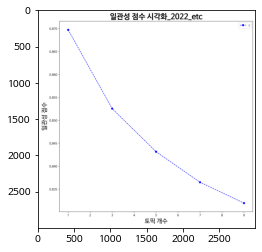

In [10]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_1}.png')

plt.imshow(image)


In [ ]:
%%time 
lda_model_2022_etc = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [14]:
coherence_lda_model = CoherenceModel(model=lda_model_2022_etc, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8608894521275001


In [15]:
topics = lda_model_2022_etc.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.053*"사람" + 0.029*"연대" + 0.025*"수준" + 0.020*"군대" + 0.019*"여자" + 0.018*"문제" + 0.017*"진짜" + 0.016*"의대" + 0.016*"학교" + 0.015*"새끼"
0.042*"생각" + 0.035*"장애인" + 0.025*"의사" + 0.023*"정신병자" + 0.019*"거지" + 0.017*"남자" + 0.016*"면허" + 0.013*"제도" + 0.010*"단체" + 0.010*"장애"


In [ ]:
lda_vis_2022_etc = pyLDAvis.gensim_models.prepare(lda_model_2022_etc, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2022_etc, '/content/drive/MyDrive/LIS3813/images/lda_vis_2022_etc.html')
pyLDAvis.display(lda_vis_2022_etc)

## 2021년도 

In [ ]:
dic, texts, corpus = get_dct_corpus('2021')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 72008/72008 [00:00<00:00, 464184.41it/s]


Number of unique tokens: 2983
Number of documents: 72007


In [ ]:
y_q = '2021'
coherence_scores_fig(dic, texts, corpus, y_q)

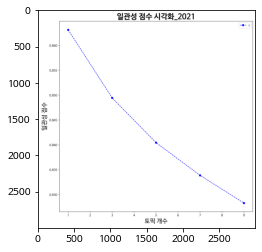

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
%%time 
lda_model_2021 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)
#약 7분 걸림

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2021, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8558957972767627
CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.53 s


In [ ]:
topics = lda_model_2021.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.093*"여자" + 0.027*"여성" + 0.019*"페미니즘" + 0.014*"차별" + 0.013*"거지" + 0.008*"평등" + 0.007*"한국" + 0.007*"흑인" + 0.007*"자체" + 0.007*"수준"
0.048*"남자" + 0.035*"고추" + 0.034*"기부" + 0.034*"진리" + 0.034*"생각" + 0.031*"사람" + 0.014*"남성" + 0.010*"군대" + 0.010*"혐오" + 0.010*"사회"


'"연대"'

In [ ]:
lda_vis_2021 = pyLDAvis.gensim_models.prepare(lda_model_2021, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021.html')
pyLDAvis.display(lda_vis_2021)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 2021년도 1분기

In [ ]:
dic, texts, corpus = get_dct_corpus('2021_Q1')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 7564/7564 [00:00<00:00, 464070.50it/s]


Number of unique tokens: 434
Number of documents: 7563


In [ ]:
y_q = '2021_Q1'
coherence_scores_fig(dic, texts, corpus, y_q)

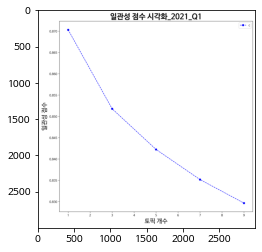

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2021_Q1 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_Q1, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8600042969712702


In [ ]:
topics = lda_model_2021_Q1.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.054*"여자" + 0.053*"사람" + 0.040*"여성" + 0.022*"거지" + 0.020*"한남" + 0.016*"사회" + 0.016*"평등" + 0.015*"한국" + 0.013*"주장" + 0.013*"페미니스트"
0.057*"생각" + 0.054*"남자" + 0.040*"페미니즘" + 0.031*"남성" + 0.028*"차별" + 0.025*"여대" + 0.020*"혐오" + 0.013*"군대" + 0.013*"학교" + 0.012*"집단"


In [ ]:
lda_vis_2021_Q1 = pyLDAvis.gensim_models.prepare(lda_model_2021_Q1, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_Q1, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_Q1.html')
pyLDAvis.display(lda_vis_2021_Q1)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 2021년도 2분기

In [ ]:
dic, texts, corpus = get_dct_corpus('2021_Q2')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 23676/23676 [00:00<00:00, 422938.81it/s]


Number of unique tokens: 1270
Number of documents: 23675


In [ ]:
y_q = '2021_Q2'
coherence_scores_fig(dic, texts, corpus, y_q)

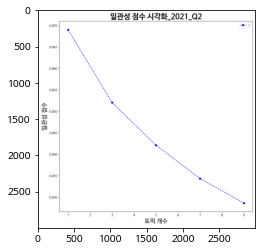

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2021_Q2 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_Q2, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8591730789253721


In [ ]:
topics = lda_model_2021_Q2.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.074*"여자" + 0.069*"남자" + 0.038*"생각" + 0.032*"사람" + 0.023*"페미니즘" + 0.017*"문제" + 0.014*"사회" + 0.010*"이유" + 0.008*"자체" + 0.008*"능력"
0.033*"여성" + 0.018*"남성" + 0.015*"차별" + 0.013*"거지" + 0.012*"군대" + 0.011*"혐오" + 0.010*"페미니스트" + 0.010*"지금" + 0.010*"한남" + 0.009*"평등"


In [ ]:
lda_vis_2021_Q2 = pyLDAvis.gensim_models.prepare(lda_model_2021_Q2, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_Q2, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_Q2.html')
pyLDAvis.display(lda_vis_2021_Q2)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 2022년도 3분기

In [ ]:
dic, texts, corpus = get_dct_corpus('2021_Q3')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 16849/16849 [00:00<00:00, 543338.21it/s]


Number of unique tokens: 961
Number of documents: 16848


In [ ]:
y_q = '2021_Q3'
coherence_scores_fig(dic, texts, corpus, y_q)

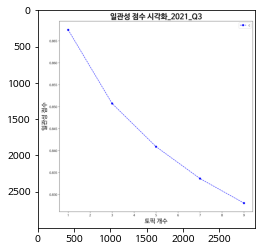

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2021_Q3 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_Q3, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8586941556848287


In [ ]:
topics = lda_model_2021_Q3.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.050*"생각" + 0.049*"사람" + 0.034*"여성" + 0.028*"군대" + 0.015*"문제" + 0.014*"거지" + 0.012*"한남" + 0.010*"페미니즘" + 0.009*"얘기" + 0.009*"여대"
0.074*"여자" + 0.060*"남자" + 0.011*"남성" + 0.009*"차별" + 0.009*"정도" + 0.008*"수준" + 0.008*"본인" + 0.008*"지금" + 0.007*"나도" + 0.007*"친구"


In [ ]:
lda_vis_2021_Q3 = pyLDAvis.gensim_models.prepare(lda_model_2021_Q3, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_Q3, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_Q3.html')
pyLDAvis.display(lda_vis_2021_Q3)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 2021년 4분기

In [ ]:
dic, texts, corpus = get_dct_corpus('2021_Q4')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 25765/25765 [00:00<00:00, 115484.14it/s]


Number of unique tokens: 1301
Number of documents: 25764


In [ ]:
y_q = '2021_Q4'
coherence_scores_fig(dic, texts, corpus, y_q)

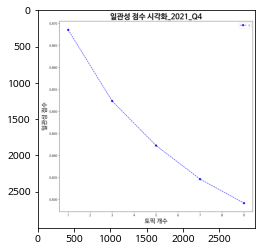

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2021_Q4 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_Q4, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.859394586012312


In [ ]:
topics = lda_model_2021_Q4.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.042*"사람" + 0.035*"생각" + 0.020*"여성" + 0.011*"이해" + 0.010*"외모" + 0.009*"여경" + 0.009*"내가" + 0.009*"군대" + 0.009*"차별" + 0.008*"이상"
0.089*"여자" + 0.062*"남자" + 0.015*"설거지" + 0.015*"결혼" + 0.014*"거지" + 0.014*"한남" + 0.013*"능력" + 0.013*"문제" + 0.011*"혐오" + 0.010*"처녀"


In [ ]:
lda_vis_2021_Q4 = pyLDAvis.gensim_models.prepare(lda_model_2021_Q4, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_Q4, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_Q4.html')
pyLDAvis.display(lda_vis_2021_Q4)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## 2022년도 1분기 : 22-1분기는 okt.nouns로 간단하게 추출함, 작동이 잘 안되어서

In [ ]:
dic, texts, corpus = get_dct_corpus('2022_Q1')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 35507/35507 [00:00<00:00, 618990.06it/s]


Number of unique tokens: 1710
Number of documents: 35506


In [ ]:
y_q = '2022_Q1'
coherence_scores_fig(dic, texts, corpus, y_q)

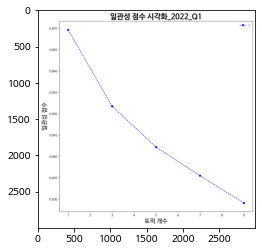

In [ ]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2022_Q1 = LdaModel(corpus=corpus, num_topics=3, id2word=dic, passes=50, random_state=42)

In [ ]:
coherence_lda_model = CoherenceModel(model=lda_model_2022_Q1, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.852592234561529


In [ ]:
topics = lda_model_2022_Q1.print_topics()

for i, topic in enumerate(topics):
  print(topic[1])

0.045*"사람" + 0.033*"중국" + 0.021*"여성" + 0.016*"자기" + 0.015*"문제" + 0.013*"지금" + 0.013*"보고" + 0.011*"전라도" + 0.010*"수준" + 0.009*"본인"
0.094*"여자" + 0.059*"남자" + 0.047*"생각" + 0.029*"그냥" + 0.015*"한국" + 0.015*"사회" + 0.014*"혐오" + 0.013*"우리" + 0.013*"때문" + 0.011*"페미니즘"
0.071*"페미" + 0.040*"진짜" + 0.016*"군대" + 0.014*"한남" + 0.013*"나라" + 0.012*"짱깨" + 0.011*"정도" + 0.010*"에타" + 0.009*"이유" + 0.009*"사실"


In [ ]:
lda_vis_2022_Q1 = pyLDAvis.gensim_models.prepare(lda_model_2022_Q1, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2022_Q1, '/content/drive/MyDrive/LIS3813/images/lda_vis_2022_Q1.html')
pyLDAvis.display(lda_vis_2022_Q1)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
